This is the code I used for the analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

In [ ]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [ ]:
import statsmodels.api as sm

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
from scipy.stats import bootstrap

In [ ]:
from scipy import stats

In [ ]:
import sys

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
%load_ext rpy2.ipython

These datasets are available on request

In [ ]:

df_trends = pd.read_csv("/content/drive/MyDrive/school_stuff/Diss/Data/google_trends_full_1.csv")

In [ ]:
df_comp_list = pd.read_csv("/content/drive/MyDrive/school_stuff/Diss/Data/company_search_good.csv")

In [ ]:
df_stocks = pd.read_csv("/content/drive/MyDrive/school_stuff/Diss/Data/stock_price_big_2.csv",  parse_dates=['date'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,15,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_sent = pd.read_csv("/content/drive/MyDrive/school_stuff/Diss/Data/brain_sent_full_1.csv")

In [ ]:
df_cds = pd.read_csv("/content/drive/MyDrive/school_stuff/Diss/Data/CDS_big_2.csv",  parse_dates=['Date'])

In [ ]:
df_SP_100 = pd.read_csv("/content/drive/MyDrive/school_stuff/Diss/Data/SP_100.csv")

In [ ]:
df_cds.columns

Index(['Date', 'Batch', 'Ticker', 'ShortName', 'RedCode', 'Sector', 'Region',
       'Country', 'AvRating', 'ImpliedRating', 'Tier', 'Currency', 'DocClause',
       'PrimaryCurve', 'PrimaryPriceType', 'RunningCoupon', 'PrimaryCoupon',
       'Tenor', 'ParSpread', 'ConvSpreard', 'Upfront', 'CDSRealRecovery',
       'CDSAssumedRecovery', 'CarriedForward', 'CompositeDepth5Y',
       'PrimaryDepthContributed', 'PrimaryDepthPassed', 'RiskyPV01', 'DP',
       'DTZ'],
      dtype='object')

In [ ]:
df_cds.head()

,Date,Batch,Ticker,ShortName,RedCode,Sector,Region,Country,AvRating,ImpliedRating,...,Upfront,CDSRealRecovery,CDSAssumedRecovery,CarriedForward,CompositeDepth5Y,PrimaryDepthContributed,PrimaryDepthPassed,RiskyPV01,DP,DTZ
0,2015-01-01,EOD,A,Agilent Tech Inc,008CA0,Healthcare,N.Amer,United States,BBB,BBB,...,0.004679,0.4,0.4,NaN,3.0,NaN,NaN,4.91,0.093853,9953206.16
1,2015-01-02,EOD,A,Agilent Tech Inc,008CA0,Healthcare,N.Amer,United States,BBB,BBB,...,0.005641,0.4,0.4,NaN,3.0,NaN,NaN,4.90,0.095195,9943594.50
2,2015-01-05,EOD,A,Agilent Tech Inc,008CA0,Healthcare,N.Amer,United States,BBB,BBB,...,0.005634,0.4,0.4,NaN,3.0,NaN,NaN,4.89,0.095035,9943661.97
3,2015-01-06,EOD,A,Agilent Tech Inc,008CA0,Healthcare,N.Amer,United States,BBB,BBB,...,0.005632,0.4,0.4,NaN,3.0,NaN,NaN,4.89,0.094963,9943677.58
4,2015-01-07,EOD,A,Agilent Tech Inc,008CA0,Healthcare,N.Amer,United States,BBB,BBB,...,0.005642,0.4,0.4,NaN,3.0,NaN,NaN,4.90,0.094886,9943583.37


In [ ]:
drop_list = ['SUN', 'TAP', 'STZ', 'DOW', 'DD', 'CYT', 'DVA', 'MAN', 'HSC', 'AMZN'] #Drop these stocks from the data set

In [ ]:
df_trends['date'] = pd.to_datetime(df_trends['date']).dt.strftime('%Y-%m-%d')

In [ ]:
df_trends

,ticker,date,svi,count
0,A,2015-06-07,84.0,1.0
1,A,2015-06-14,0.0,1.0
2,A,2015-06-21,0.0,1.0
3,A,2015-06-28,0.0,1.0
4,A,2015-07-05,39.0,1.0
...,...,...,...,...
107626,YUM,2022-05-01,60.0,1.0
107627,YUM,2022-05-08,49.0,1.0
107628,YUM,2022-05-15,36.0,1.0
107629,YUM,2022-05-22,52.0,1.0


In [ ]:
df_sent['date'] = pd.to_datetime(df_sent['CALCULATION_DATE']) - pd.DateOffset(days=8)

In [ ]:
df_sent[df_sent['date'].isin(list(df_trends['date']))]

,CALCULATION_DATE,NAME,SHARE_CLASS_FIGI,COMPOSITE_FIGI,PRIMARY_EXCHANGE_TICKER,PRIMARY_EXCHANGE,COUNTRY,REGION,VOLUME,VOLUME_SENTIMENT,SENTIMENT_SCORE,BUZZ_VOLUME,BUZZ_VOLUME_SENTIMENT,date
5548,2019-07-15,AGILENT TECHNOLOGIES INC,BBG001SCTQY4,BBG000C2V3D6,A,NYSE,UNITED STATES,NORTH AMERICA,12,7,0.3346,-1.3392,-1.0957,2019-07-07
5549,2019-07-15,ALCOA CORP,BBG00B3T3HF1,BBG00B3T3HD3,AA,NYSE,UNITED STATES,NORTH AMERICA,3,3,-0.1897,-1.4126,-1.1430,2019-07-07
5550,2019-07-15,AMERISOURCEBERGEN CORP,BBG001S8X7P0,BBG000MDCQC2,ABC,NYSE,UNITED STATES,NORTH AMERICA,3,1,0.2202,-1.2695,-1.1694,2019-07-07
5551,2019-07-15,ABBOTT LABORATORIES,BBG001S5N9M6,BBG000B9ZXB4,ABT,NYSE,UNITED STATES,NORTH AMERICA,9,5,0.3239,-1.2536,-1.0155,2019-07-07
5552,2019-07-15,ANALOG DEVICES INC,BBG001S5ND38,BBG000BB6G37,ADI,NASDAQ,UNITED STATES,NORTH AMERICA,11,7,0.2082,-1.1479,-1.0113,2019-07-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413478,2019-03-11,UNITED STATES STEEL CORP,BBG001S5XL75,BBG000BX3TD3,X,NYSE,UNITED STATES,NORTH AMERICA,36,14,0.0427,-0.2927,-0.6309,2019-03-03
413479,2019-03-11,XCEL ENERGY INC,BBG001S7F0X8,BBG000BCTQ65,XEL,NASDAQ,UNITED STATES,NORTH AMERICA,54,27,0.2683,1.4928,1.1384,2019-03-03
413480,2019-03-11,EXXON MOBIL CORP,BBG001S69V32,BBG000GZQ728,XOM,NYSE,UNITED STATES,NORTH AMERICA,234,159,0.0582,1.4434,1.7505,2019-03-03
413481,2019-03-11,DENTSPLY SIRONA INC,BBG001S5XLV8,BBG000BX57K1,XRAY,NASDAQ,UNITED STATES,NORTH AMERICA,72,24,0.3267,1.8275,1.3938,2019-03-03


In [ ]:
df_stocks.rename(columns={"TICKER": "ticker", "VOL": "vol"}, inplace=True)

In [ ]:
df_cds.rename(columns={"Ticker": "ticker", 'Date':'date'}, inplace=True)

In [ ]:
df_sent.rename(columns={"PRIMARY_EXCHANGE_TICKER": "ticker", "SENTIMENT_SCORE": "sent", "VOLUME": "art_count"}, inplace=True)

In [ ]:
df_stocks.drop(df_stocks.index[df_stocks['ticker'].isin(drop_list)], inplace=True)

In [ ]:
df_stocks.shape

(3232589, 27)

In [ ]:
df_stocks.dropna(subset=['PRC'], inplace=True)

In [ ]:
df_stocks.columns

Index(['PERMNO', 'date', 'ticker', 'COMNAM', 'CUSIP', 'SHRFLG', 'SHRENDDT',
       'TRTSCD', 'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'vol',
       'RET', 'BID', 'ASK', 'SHROUT', 'OPENPRC', 'NUMTRD', 'RETX', 'vwretd',
       'vwretx', 'ewretd', 'ewretx', 'sprtrn'],
      dtype='object')

In [ ]:
df_stocks['market_cap'] = df_stocks['PRC'] * df_stocks['SHROUT'] 

In [ ]:
market_cap_map = df_stocks.groupby(['ticker']).mean()['market_cap'].to_dict()

In [ ]:
df_stocks['market_cap_mean'] = df_stocks['ticker'].map(market_cap_map)

In [ ]:
df_stocks['td_count'] = 1 #add in flag for trading day

In [ ]:
df_stocks_week = df_stocks[['ticker','date','PRC', 'market_cap_mean', 'vol']].groupby(['ticker']).resample('W', on='date').mean().reset_index()

In [ ]:
df_stocks_week_sum = df_stocks[['ticker','date','PRC', 'vol', 'td_count']].groupby(['ticker']).resample('W', on='date').sum().reset_index()

In [ ]:
df_stocks_week['td_count'] = df_stocks_week_sum['td_count']
df_stocks_week['vol_sum'] = df_stocks_week_sum['vol']

In [ ]:
df_stocks_week_sum['td_count'].value_counts()

5     540301
4     112092
0      44193
10      5249
3       1348
8       1081
1        860
2        195
6         17
7          3
9          2
Name: td_count, dtype: int64

In [ ]:
df_stocks_week['td_count'].value_counts()

5     540301
4     112092
0      44193
10      5249
3       1348
8       1081
1        860
2        195
6         17
7          3
9          2
Name: td_count, dtype: int64

Every week, there are either 4 or 5 trading days on the NYSE and NASDAQ. Anything else needs to be cleaned out. 

In [ ]:
df_stocks_week_sum = df_stocks_week_sum[df_stocks_week_sum['td_count'].isin([4, 5])]

In [ ]:
df_stocks_week = df_stocks_week[df_stocks_week['td_count'].isin([4, 5])]

In [ ]:
df_cds_week = df_cds[['ticker','date','ParSpread']].groupby(['ticker']).resample('W', on='date').mean().reset_index()

In [ ]:
df_cds_week[df_cds_week['ticker'] == 'ADI']

,ticker,date,ParSpread
10731,ADI,2015-01-04,0.005937
10732,ADI,2015-01-11,0.005937
10733,ADI,2015-01-18,0.005937
10734,ADI,2015-01-25,0.005937
10735,ADI,2015-02-01,0.005936
...,...,...,...
11124,ADI,2022-07-17,0.006213
11125,ADI,2022-07-24,0.006216
11126,ADI,2022-07-31,0.006217
11127,ADI,2022-08-07,0.006222


In [ ]:
trend_to_comp = dict(zip(df_comp_list.mid, df_comp_list.ticker))

In [ ]:
tick_to_sect = dict(zip(df_cds.ticker, df_cds.Sector))

In [ ]:
df_trends.drop(columns=['count'], inplace=True)

In [ ]:
df_trends['date'] = pd.to_datetime(pd.to_datetime(df_trends['date']).dt.strftime("%Y-%m-%d"))

Now lets merge most of this data together.

In [ ]:
df = df_trends.merge(df_stocks_week, how='inner', on=['ticker','date'])
df = df.merge(df_cds_week, how='inner', on=['ticker','date'])

In [ ]:
df

,ticker,date,svi,PRC,market_cap_mean,vol,td_count,vol_sum,ParSpread
0,A,2015-06-07,84.000000,40.796,1.747404e+07,2792428.40,5,13962142.0,0.008360
1,A,2015-06-14,0.000000,40.192,1.747404e+07,1785658.80,5,8928294.0,0.008485
2,A,2015-06-21,0.000000,39.660,1.747404e+07,1965581.60,5,9827908.0,0.008736
3,A,2015-06-28,0.000000,39.934,1.747404e+07,4141355.60,5,20706778.0,0.008423
4,A,2015-07-05,39.000000,39.040,1.747404e+07,3050291.75,4,12201167.0,0.008363
...,...,...,...,...,...,...,...,...,...
83075,YUM,2022-03-06,49.066310,120.606,2.154346e+07,1667732.80,5,8338664.0,0.015166
83076,YUM,2022-03-13,55.358160,115.328,2.154346e+07,2196543.80,5,10982719.0,0.016846
83077,YUM,2022-03-20,36.892939,117.728,2.154346e+07,2416518.80,5,12082594.0,0.017058
83078,YUM,2022-03-27,46.384245,118.498,2.154346e+07,1604409.60,5,8022048.0,0.016272


In [ ]:
df_sent

,CALCULATION_DATE,NAME,SHARE_CLASS_FIGI,COMPOSITE_FIGI,ticker,PRIMARY_EXCHANGE,COUNTRY,REGION,art_count,VOLUME_SENTIMENT,sent,BUZZ_VOLUME,BUZZ_VOLUME_SENTIMENT,date
0,2019-12-25,AGILENT TECHNOLOGIES INC,BBG001SCTQY4,BBG000C2V3D6,A,NYSE,UNITED STATES,NORTH AMERICA,24,12,0.1681,0.0408,-0.0493,2019-12-17
1,2019-12-25,ALCOA CORP,BBG00B3T3HF1,BBG00B3T3HD3,AA,NYSE,UNITED STATES,NORTH AMERICA,47,25,0.0604,0.6913,0.9443,2019-12-17
2,2019-12-25,AMERISOURCEBERGEN CORP,BBG001S8X7P0,BBG000MDCQC2,ABC,NYSE,UNITED STATES,NORTH AMERICA,22,15,0.1263,0.0322,0.2818,2019-12-17
3,2019-12-25,ABBOTT LABORATORIES,BBG001S5N9M6,BBG000B9ZXB4,ABT,NYSE,UNITED STATES,NORTH AMERICA,45,22,0.0477,0.2762,0.1218,2019-12-17
4,2019-12-25,ANALOG DEVICES INC,BBG001S5ND38,BBG000BB6G37,ADI,NASDAQ,UNITED STATES,NORTH AMERICA,46,24,0.2145,0.6952,0.6663,2019-12-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413478,2019-03-11,UNITED STATES STEEL CORP,BBG001S5XL75,BBG000BX3TD3,X,NYSE,UNITED STATES,NORTH AMERICA,36,14,0.0427,-0.2927,-0.6309,2019-03-03
413479,2019-03-11,XCEL ENERGY INC,BBG001S7F0X8,BBG000BCTQ65,XEL,NASDAQ,UNITED STATES,NORTH AMERICA,54,27,0.2683,1.4928,1.1384,2019-03-03
413480,2019-03-11,EXXON MOBIL CORP,BBG001S69V32,BBG000GZQ728,XOM,NYSE,UNITED STATES,NORTH AMERICA,234,159,0.0582,1.4434,1.7505,2019-03-03
413481,2019-03-11,DENTSPLY SIRONA INC,BBG001S5XLV8,BBG000BX57K1,XRAY,NASDAQ,UNITED STATES,NORTH AMERICA,72,24,0.3267,1.8275,1.3938,2019-03-03


In [ ]:
df = df.merge(df_sent[['ticker','date', "sent", "art_count"]], how='left', on=['ticker','date'])

In [ ]:
df = df[df['date'] > datetime.strptime('2016-07-17', '%Y-%m-%d')].copy()

In [ ]:
df.dropna(subset=['ParSpread'], inplace=True)

In [ ]:
df.fillna(0.0, inplace=True)

In [ ]:
df.groupby(['ticker']).count()['date'].sort_values().head(20)

ticker
DG       1
STT      2
SNA      2
PNW      3
STLD    11
ASH     14
COKE    15
AA      17
JCI     27
PENN    29
SCS     39
CRS     41
VSH     44
D       46
JBL     53
NRP     58
ALB     80
PNR     80
LEG     82
WMT     84
Name: date, dtype: int64

We need to get rid of missing values

In [ ]:
df_count = df.groupby(['ticker']).count()

In [ ]:
full_comps_list = df_count[df_count['ParSpread'] == df_count['ParSpread'].max()].index  

In [ ]:
full_comps_list

Index(['A', 'ABC', 'ABT', 'ADI', 'ADM', 'ADP', 'AEP', 'AES', 'AFG', 'AIG',
       ...
       'WFC', 'WHR', 'WMB', 'WRE', 'WY', 'X', 'XEL', 'XOM', 'XRX', 'YUM'],
      dtype='object', name='ticker', length=195)

In [ ]:

df = df[df.ticker.isin(full_comps_list)].copy() #all data has the same lenght

In [ ]:
df['sector'] =  df['ticker'].map(tick_to_sect)

In [ ]:
df

,ticker,date,svi,PRC,market_cap_mean,vol,td_count,vol_sum,ParSpread,sent,art_count,sector
59,A,2016-07-24,10.666667,46.808,1.747404e+07,1762092.60,5,8810463.0,0.010475,0.3182,2.0,Healthcare
60,A,2016-07-31,15.000000,47.194,1.747404e+07,1782557.00,5,8912785.0,0.008571,0.4019,3.0,Healthcare
61,A,2016-08-07,22.166667,47.292,1.747404e+07,1532088.40,5,7660442.0,0.008761,0.2500,6.0,Healthcare
62,A,2016-08-14,27.333333,47.692,1.747404e+07,1197606.20,5,5988031.0,0.008887,-0.1277,33.0,Healthcare
63,A,2016-08-21,19.500000,47.898,1.747404e+07,3331050.00,5,16655250.0,0.008347,0.0000,0.0,Healthcare
...,...,...,...,...,...,...,...,...,...,...,...,...
83075,YUM,2022-03-06,49.066310,120.606,2.154346e+07,1667732.80,5,8338664.0,0.015166,-0.1807,37.0,Consumer Services
83076,YUM,2022-03-13,55.358160,115.328,2.154346e+07,2196543.80,5,10982719.0,0.016846,0.0268,27.0,Consumer Services
83077,YUM,2022-03-20,36.892939,117.728,2.154346e+07,2416518.80,5,12082594.0,0.017058,0.2055,20.0,Consumer Services
83078,YUM,2022-03-27,46.384245,118.498,2.154346e+07,1604409.60,5,8022048.0,0.016272,0.1121,24.0,Consumer Services


In [ ]:
df.drop_duplicates('ticker')['sector'].value_counts()

Industrials                    32
Financials                     31
Consumer Services              30
Consumer Goods                 27
Healthcare                     21
Technology                     16
Energy                         14
Utilities                      12
Basic Materials                11
Telecommunications Services     1
Name: sector, dtype: int64

Now, we need to get our actual data. 

In [ ]:
df['svi_ln'] = np.log(df['svi']+1)#helps with num stability 
df['PRC_ln'] = np.log(df['PRC'])
df['Par_ln'] = np.log(df['ParSpread'])
df['vol_ln'] = np.log(df['vol'])
df['vol_sum_ln'] = np.log(df['vol_sum'])
df['count_ln'] = np.log(df['art_count']+1)

#df['svi_med'] = df.groupby(['ticker']).rolling(8, closed='left')['svi_ln'].median()

df['svi_diff'] = df.groupby(['ticker'])['svi_ln'].diff(periods=1)
df['svi_med'] = (df['svi_ln'] - df.groupby(['ticker']).rolling(8, closed='left')['svi_ln'].median().droplevel('ticker'))
df['count_diff'] = df.groupby(['ticker'])['count_ln'].diff(periods=1)
df['count_med'] = (df['count_ln'] - df.groupby(['ticker']).rolling(8, closed='left')['count_ln'].median().droplevel('ticker'))
df['PRC_diff'] = df.groupby(['ticker'])['PRC_ln'].diff(periods=1)
df['Par_diff'] = df.groupby(['ticker'])['Par_ln'].diff(periods=1)
df['vol_diff'] = df.groupby(['ticker'])['vol_ln'].diff(periods=1)
df['vol_sum_diff'] = df.groupby(['ticker'])['vol_sum_ln'].diff(periods=1)

df.drop(columns=['svi_ln', 'PRC_ln', 'Par_ln', 'vol_ln', 'vol_sum_ln', 'count_ln'], inplace=True)


In [ ]:
df

,ticker,date,svi,PRC,market_cap_mean,vol,td_count,vol_sum,ParSpread,sent,art_count,sector,svi_diff,svi_med,count_diff,count_med,PRC_diff,Par_diff,vol_diff,vol_sum_diff
59,A,2016-07-24,10.666667,46.808,1.747404e+07,1762092.60,5,8810463.0,0.010475,0.3182,2.0,Healthcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,A,2016-07-31,15.000000,47.194,1.747404e+07,1782557.00,5,8912785.0,0.008571,0.4019,3.0,Healthcare,0.315853,NaN,0.287682,NaN,0.008213,-0.200643,0.011547,0.011547
61,A,2016-08-07,22.166667,47.292,1.747404e+07,1532088.40,5,7660442.0,0.008761,0.2500,6.0,Healthcare,0.370126,NaN,0.559616,NaN,0.002074,0.021982,-0.151417,-0.151417
62,A,2016-08-14,27.333333,47.692,1.747404e+07,1197606.20,5,5988031.0,0.008887,-0.1277,33.0,Healthcare,0.201325,NaN,1.580450,NaN,0.008423,0.014187,-0.246307,-0.246307
63,A,2016-08-21,19.500000,47.898,1.747404e+07,3331050.00,5,16655250.0,0.008347,0.0000,0.0,Healthcare,-0.323614,NaN,-3.526361,NaN,0.004310,-0.062617,1.022963,1.022963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83075,YUM,2022-03-06,49.066310,120.606,2.154346e+07,1667732.80,5,8338664.0,0.015166,-0.1807,37.0,Consumer Services,0.090002,0.076109,0.929536,0.260284,-0.017091,0.017127,-0.191900,0.031244
83076,YUM,2022-03-13,55.358160,115.328,2.154346e+07,2196543.80,5,10982719.0,0.016846,0.0268,27.0,Consumer Services,0.118379,0.149487,-0.305382,-0.045098,-0.044749,0.105043,0.275420,0.275420
83077,YUM,2022-03-20,36.892939,117.728,2.154346e+07,2416518.80,5,12082594.0,0.017058,0.2055,20.0,Consumer Services,-0.396962,-0.330047,-0.287682,-0.369834,0.020597,0.012535,0.095443,0.095443
83078,YUM,2022-03-27,46.384245,118.498,2.154346e+07,1604409.60,5,8022048.0,0.016272,0.1121,24.0,Consumer Services,0.223525,-0.023951,0.174353,-0.195480,0.006519,-0.047165,-0.409572,-0.409572


In [ ]:
df[['svi_diff', 'PRC_diff',	'Par_diff', 'vol_diff', 'sent', 'art_count']].describe()

,svi_diff,PRC_diff,Par_diff,vol_diff,sent,art_count
count,57915.000000,57915.000000,57915.000000,57915.000000,58110.000000,58110.000000
mean,-0.000273,0.001658,-0.000103,0.000215,0.122178,41.445775
std,1.065498,0.047099,0.060823,0.351539,0.200615,71.553343
min,-4.615121,-0.999453,-0.988224,-2.471566,-0.921700,0.000000
25%,-0.329417,-0.014586,-0.018176,-0.220768,0.000000,8.000000
50%,-0.005013,0.002997,-0.000093,-0.015580,0.128000,21.000000
75%,0.328167,0.019724,0.011732,0.205861,0.250000,46.000000
max,4.689289,3.034845,1.283080,2.570299,0.954500,1408.000000


In [ ]:
df.columns

Index(['ticker', 'date', 'svi', 'PRC', 'market_cap_mean', 'vol', 'td_count',
       'vol_sum', 'ParSpread', 'sent', 'art_count', 'sector', 'svi_diff',
       'svi_med', 'count_diff', 'count_med', 'PRC_diff', 'Par_diff',
       'vol_diff', 'vol_sum_diff'],
      dtype='object')

In [ ]:
df = df[df['ticker'] != 'CHK'] # bad data point

In [ ]:
df = df[df['ticker'] != 'XRX'] # bad data point

In [ ]:
df_clean = df.dropna().copy() #remove more NA values

In [ ]:
df_clean['ticker'].value_counts().sort_values()

A       290
AYI     290
AMAT    290
ABT     290
ADI     290
       ... 
WY      290
X       290
XEL     290
PBI     290
YUM     290
Name: ticker, Length: 194, dtype: int64

In [ ]:
df_clean["time_idx"] = df_clean['date'].astype('category').cat.codes

In [ ]:
df_count = df_clean.groupby(['ticker']).count()

In [ ]:
full_comps_list = df_count[df_count['ParSpread'] == df_count['ParSpread'].max()].index  
df_clean = df_clean[df_clean.ticker.isin(full_comps_list)].copy()

In [ ]:
#del df_cds, df_stocks

In [ ]:
df_clean['ticker'].value_counts().sort_values()

A       290
AYI     290
AMAT    290
ABT     290
ADI     290
       ... 
WY      290
X       290
XEL     290
PBI     290
YUM     290
Name: ticker, Length: 194, dtype: int64

In [ ]:
#df_clean.to_csv('/content/drive/MyDrive/school_stuff/Diss/Data/data_frame_clean.csv', index=False)

In [ ]:
var_list = ['svi_med', 'PRC_diff',	'Par_diff', 'vol_diff', 'sent', 'count_med'] #var list used later

In [ ]:
df_summary= df_clean[var_list].describe().T.round({'count':0, 'mean':4, 'std':4, 'min':4, '25%':4, '50%':4, '75%':4, 'max':4})

In [ ]:
df_summary['count'] = df_summary['count'].astype('int64')

In [ ]:
df_summary

,count,mean,std,min,25%,50%,75%,max
svi_med,56260,-0.0659,0.8642,-4.2010,-0.2857,-0.0024,0.2921,4.4942
PRC_diff,56260,0.0017,0.0473,-0.9995,-0.0146,0.0032,0.0200,3.0348
Par_diff,56260,-0.0000,0.0612,-0.9882,-0.0181,-0.0001,0.0118,1.2831
vol_diff,56260,-0.0004,0.3507,-2.4716,-0.2210,-0.0163,0.2051,2.5703
sent,56260,0.1235,0.1985,-0.9217,0.0000,0.1288,0.2500,0.9545
count_med,56260,0.0317,0.8439,-4.3882,-0.3914,0.0014,0.4614,4.6040


In [ ]:
df_summary.to_latex() #Summary stats used later

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &  count &    mean &     std &     min &     25\\% &     50\\% &     75\\% &     max \\\\\n\\midrule\nsvi\\_med   &  56260 & -0.0659 &  0.8642 & -4.2010 & -0.2857 & -0.0024 &  0.2921 &  4.4942 \\\\\nPRC\\_diff  &  56260 &  0.0017 &  0.0473 & -0.9995 & -0.0146 &  0.0032 &  0.0200 &  3.0348 \\\\\nPar\\_diff  &  56260 & -0.0000 &  0.0612 & -0.9882 & -0.0181 & -0.0001 &  0.0118 &  1.2831 \\\\\nvol\\_diff  &  56260 & -0.0004 &  0.3507 & -2.4716 & -0.2210 & -0.0163 &  0.2051 &  2.5703 \\\\\nsent      &  56260 &  0.1235 &  0.1985 & -0.9217 &  0.0000 &  0.1288 &  0.2500 &  0.9545 \\\\\ncount\\_med &  56260 &  0.0317 &  0.8439 & -4.3882 & -0.3914 &  0.0014 &  0.4614 &  4.6040 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df_clean[['svi', 'PRC',	'ParSpread', 'vol', 'sent', 'art_count']].describe()

,svi,PRC,ParSpread,vol,sent,art_count
count,56260.000000,56260.000000,56260.000000,5.626000e+04,56260.000000,56260.000000
mean,37.906141,114.926013,0.011839,5.244164e+06,0.123550,42.502915
std,21.851025,273.305624,0.021279,1.052791e+07,0.198454,72.406787
min,0.000000,0.465050,0.001097,8.596200e+03,-0.921700,0.000000
25%,22.333333,38.172750,0.004125,1.162367e+06,0.000000,8.000000
50%,37.166667,70.805000,0.006580,2.373868e+06,0.128850,21.000000
75%,51.833333,125.966500,0.010467,4.786018e+06,0.250000,47.000000
max,147.969898,5892.754004,0.520575,2.333172e+08,0.954500,1408.000000


In [ ]:
df_clean[['svi_med', 'PRC_diff',	'Par_diff', 'vol_diff', 'sent', 'count_diff']].describe()

,svi_med,PRC_diff,Par_diff,vol_diff,sent,count_diff
count,56260.000000,56260.000000,56260.000000,56260.000000,56260.000000,56260.000000
mean,-0.065851,0.001700,-0.000015,-0.000396,0.123550,0.005660
std,0.864171,0.047292,0.061203,0.350715,0.198454,0.920380
min,-4.200953,-0.999453,-0.988224,-2.471566,-0.921700,-4.905275
25%,-0.285678,-0.014626,-0.018136,-0.221013,0.000000,-0.447607
50%,-0.002405,0.003177,-0.000082,-0.016298,0.128850,0.000000
75%,0.292124,0.019984,0.011837,0.205105,0.250000,0.456758
max,4.494239,3.034845,1.283080,2.570299,0.954500,4.779123


In [ ]:
market_cap_median = df_clean['market_cap_mean'].median()

In [ ]:
df_clean['year'] = df_clean['date'].dt.strftime("%Y")

In [ ]:
df_clean

,ticker,date,svi,PRC,market_cap_mean,vol,td_count,vol_sum,ParSpread,sent,...,svi_diff,svi_med,count_diff,count_med,PRC_diff,Par_diff,vol_diff,vol_sum_diff,time_idx,year
67,A,2016-09-18,0.000000,45.148,1.747404e+07,2245778.60,5,11228893.0,0.008125,0.2598,...,-3.486355,-3.081570,0.485508,1.067083,-0.029291,-0.159956,0.339790,0.562933,0,2016
68,A,2016-09-25,0.000000,45.996,1.747404e+07,1827572.80,5,9137864.0,0.008655,0.3046,...,0.000000,-3.081570,-0.167054,0.620221,0.018608,0.063169,-0.206064,-0.206064,1,2016
69,A,2016-10-02,0.000000,46.790,1.747404e+07,1884254.00,5,9421270.0,0.008422,0.4588,...,0.000000,-3.081570,-1.011601,-0.626381,0.017115,-0.027292,0.030543,0.030543,2,2016
70,A,2016-10-09,17.000000,47.160,1.747404e+07,1634361.20,5,8171806.0,0.008056,-0.0165,...,2.890372,-0.125971,0.223144,-0.235002,0.007877,-0.044475,-0.142280,-0.142280,3,2016
71,A,2016-10-16,15.000000,45.818,1.747404e+07,1705346.20,5,8526731.0,0.008631,0.2301,...,-0.117783,-0.178728,0.470004,0.470004,-0.028869,0.068952,0.042516,0.042516,4,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83075,YUM,2022-03-06,49.066310,120.606,2.154346e+07,1667732.80,5,8338664.0,0.015166,-0.1807,...,0.090002,0.076109,0.929536,0.260284,-0.017091,0.017127,-0.191900,0.031244,285,2022
83076,YUM,2022-03-13,55.358160,115.328,2.154346e+07,2196543.80,5,10982719.0,0.016846,0.0268,...,0.118379,0.149487,-0.305382,-0.045098,-0.044749,0.105043,0.275420,0.275420,286,2022
83077,YUM,2022-03-20,36.892939,117.728,2.154346e+07,2416518.80,5,12082594.0,0.017058,0.2055,...,-0.396962,-0.330047,-0.287682,-0.369834,0.020597,0.012535,0.095443,0.095443,287,2022
83078,YUM,2022-03-27,46.384245,118.498,2.154346e+07,1604409.60,5,8022048.0,0.016272,0.1121,...,0.223525,-0.023951,0.174353,-0.195480,0.006519,-0.047165,-0.409572,-0.409572,288,2022


In [ ]:
sp_100_list = list(df_SP_100['Ticker']) #better way than market cap

In [ ]:

df_large = df_clean[df_clean['ticker'].isin(sp_100_list)]

In [ ]:

df_small = df_clean[~df_clean['ticker'].isin(sp_100_list)]

In [ ]:
len(df_large['ticker'].value_counts())

50

In [ ]:
df_large[var_list].describe()['svi_med']

count    14500.000000
mean         0.008852
std          0.345193
min         -4.096654
25%         -0.175568
50%         -0.014432
75%          0.173963
max          2.525369
Name: svi_med, dtype: float64

In [ ]:
df_small[var_list].describe()['svi_med']

count    41760.000000
mean        -0.091789
std          0.980875
min         -4.200953
25%         -0.367113
50%          0.000000
75%          0.352195
max          4.494239
Name: svi_med, dtype: float64

In [ ]:
df_svi_diff = pd.DataFrame([df_large[var_list].describe()['svi_med'],df_small[var_list].describe()['svi_med']], index=['svi_large', 'svi_small']).round({'count':0, 'mean':4, 'std':4, 'min':4, '25%':4, '50%':4, '75%':4, 'max':4})

In [ ]:
df_svi_diff['count'] = df_svi_diff['count'].astype('int64')

In [ ]:
df_svi_diff

,count,mean,std,min,25%,50%,75%,max
svi_large,14500,0.0089,0.3452,-4.0967,-0.1756,-0.0144,0.1740,2.5254
svi_small,41760,-0.0918,0.9809,-4.2010,-0.3671,0.0000,0.3522,4.4942


In [ ]:
df_svi_diff.to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &  count &    mean &     std &     min &     25\\% &     50\\% &     75\\% &     max \\\\\n\\midrule\nsvi\\_large &  14500 &  0.0089 &  0.3452 & -4.0967 & -0.1756 & -0.0144 &  0.1740 &  2.5254 \\\\\nsvi\\_small &  41760 & -0.0918 &  0.9809 & -4.2010 & -0.3671 &  0.0000 &  0.3522 &  4.4942 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df_small['ticker'].value_counts()

A      290
ABC    290
MBI    290
MCK    290
MDC    290
      ... 
ED     290
EFX    290
EL     290
EMN    290
YUM    290
Name: ticker, Length: 144, dtype: int64

In [ ]:
print(df_small['ticker'].value_counts().sort_index()[:50])

A       290
ABC     290
ADI     290
ADM     290
ADP     290
AEP     290
AES     290
AFG     290
ALL     290
AMAT    290
AMD     290
AMKR    290
AN      290
APA     290
APD     290
ARW     290
AVB     290
AVT     290
AXL     290
AYI     290
AZO     290
BAX     290
BBY     290
BC      290
BDX     290
BEN     290
BSX     290
BWA     290
BXP     290
BYD     290
BZH     290
CAH     290
CCI     290
CLX     290
CMS     290
CPT     290
CSX     290
CYH     290
DAL     290
DDS     290
DE      290
DGX     290
DHI     290
DLX     290
DOV     290
DRI     290
DTE     290
DVN     290
ED      290
EFX     290
Name: ticker, dtype: int64


In [ ]:
np.unique(df_clean['ticker'])[:10]

array(['A', 'ABC', 'ABT', 'ADI', 'ADM', 'ADP', 'AEP', 'AES', 'AFG', 'AIG'],
      dtype=object)

In [ ]:
df_clean.drop_duplicates(subset='ticker').sector.value_counts()

Industrials                    32
Financials                     31
Consumer Services              30
Consumer Goods                 27
Healthcare                     21
Technology                     15
Energy                         14
Utilities                      12
Basic Materials                11
Telecommunications Services     1
Name: sector, dtype: int64

# Data analysis

Here are the histograms of the data.

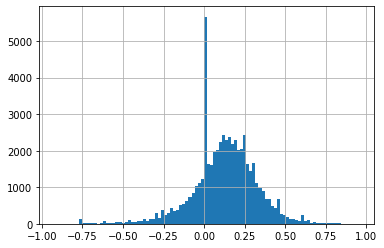

In [ ]:
_ = df_clean['sent'].hist(bins=100)

Note that zero is the default value if there's no news

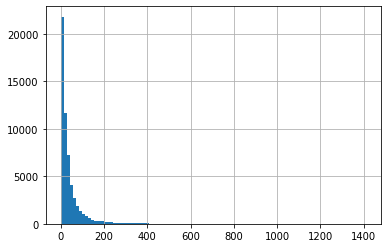

In [ ]:
_ = df_clean['art_count'].hist(bins=100)

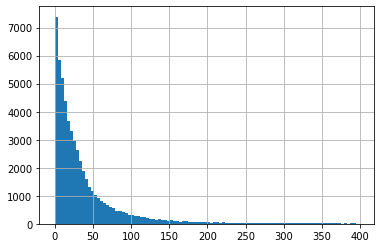

In [ ]:
_ = df_clean[df_clean['art_count'] < 400]['art_count'].hist(bins=100)

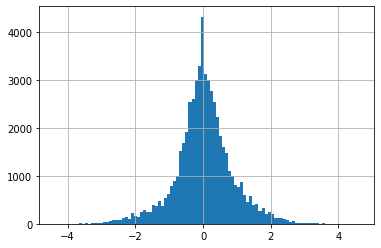

In [ ]:
_ = df_clean['count_med'].hist(bins=100)

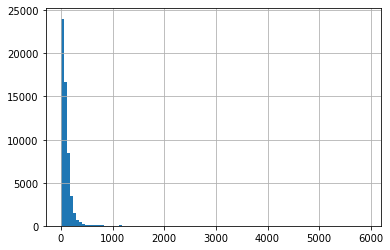

In [ ]:
_ = df_clean['PRC'].hist(bins=100)

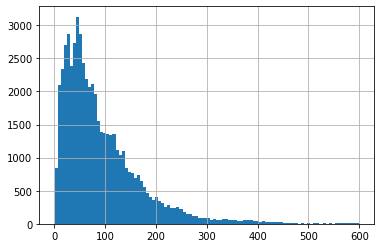

In [ ]:
_ = df_clean[df_clean['PRC'] < 600]['PRC'].hist(bins=100)

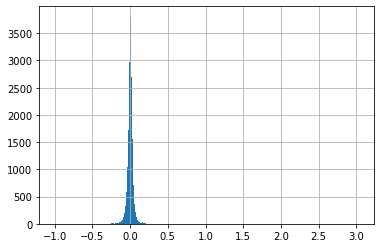

In [ ]:
_ = df_clean['PRC_diff'].hist(bins=1000)

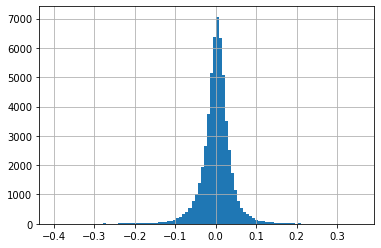

In [ ]:
_ = df_clean[(df_clean['PRC_diff'] < 0.4) & (df_clean['PRC_diff'] > -0.4)]['PRC_diff'].hist(bins=100)

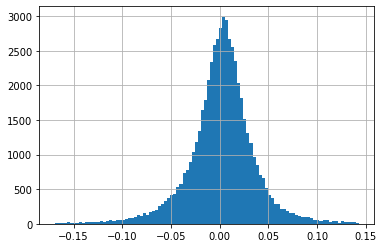

In [ ]:
alp = 0.005
pd_series = df_clean['PRC_diff']
pd_series_adjusted = pd_series[pd_series.between(pd_series.quantile(alp), pd_series.quantile(1-alp))]
_ = pd_series_adjusted.hist(bins=100)

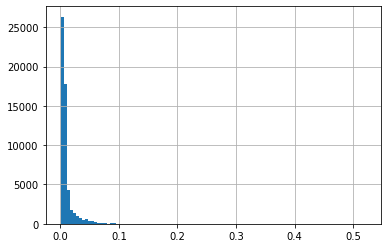

In [ ]:
_ = df_clean['ParSpread'].hist(bins=100)

0.00109673


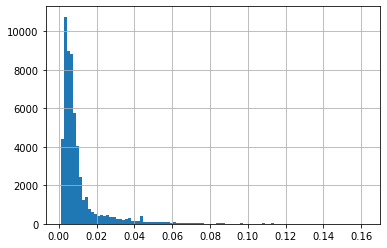

In [ ]:
alp = 0.005
pd_series = df_clean['ParSpread']
pd_series_adjusted = pd_series[pd_series.between(min([pd_series.quantile(alp),0]), pd_series.quantile(1-alp))]
_ = pd_series_adjusted.hist(bins=100)
print(min(pd_series_adjusted))

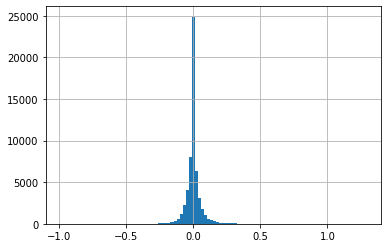

In [ ]:
_ = df_clean['Par_diff'].hist(bins=100)

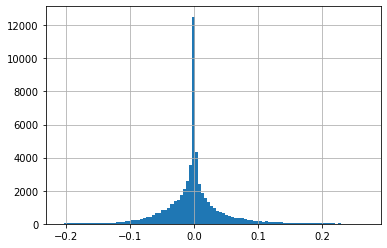

In [ ]:
alp = 0.005
pd_series = df_clean['Par_diff']
pd_series_adjusted = pd_series[pd_series.between(min([pd_series.quantile(alp),0]), pd_series.quantile(1-alp))]
_ = pd_series_adjusted.hist(bins=100)

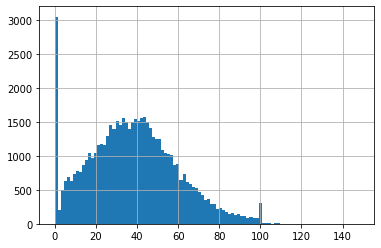

In [ ]:
_ = df_clean['svi'].hist(bins=100)

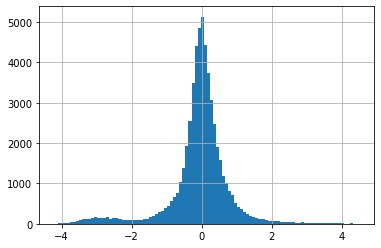

In [ ]:
_ = df_clean['svi_med'].hist(bins=100)

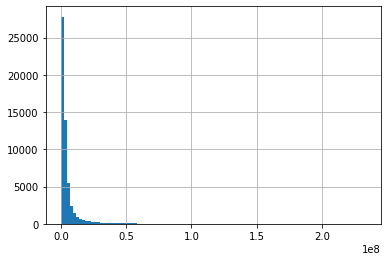

In [ ]:
_ = df_clean['vol'].hist(bins=100)

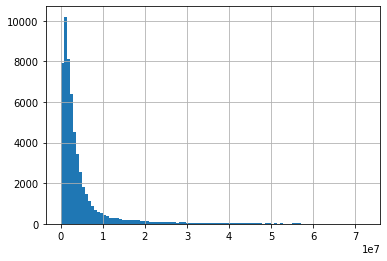

In [ ]:
alp = 0.005
pd_series = df_clean['vol']
pd_series_adjusted = pd_series[pd_series.between(min([pd_series.quantile(alp),0]), pd_series.quantile(1-alp))]
_ = pd_series_adjusted.hist(bins=100)

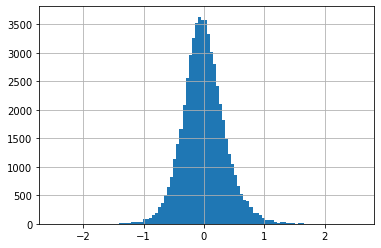

In [ ]:
_ = df_clean['vol_diff'].hist(bins=100)

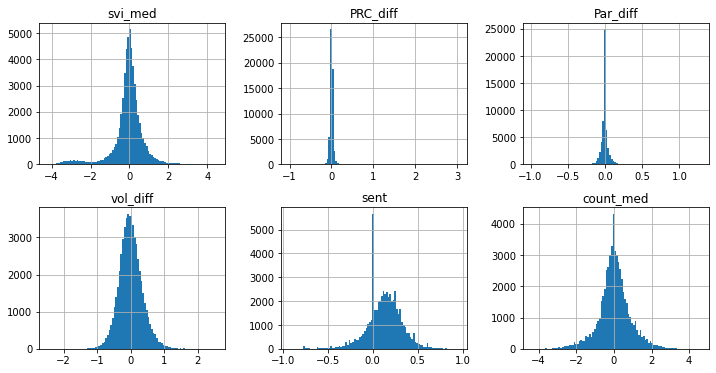

In [ ]:
#.tight_layout()
_ = df_clean[['svi_med', 'PRC_diff',	'Par_diff', 'vol_diff', 'sent', 'count_med']].hist(layout=(2,3), bins=100, figsize=(12,6))


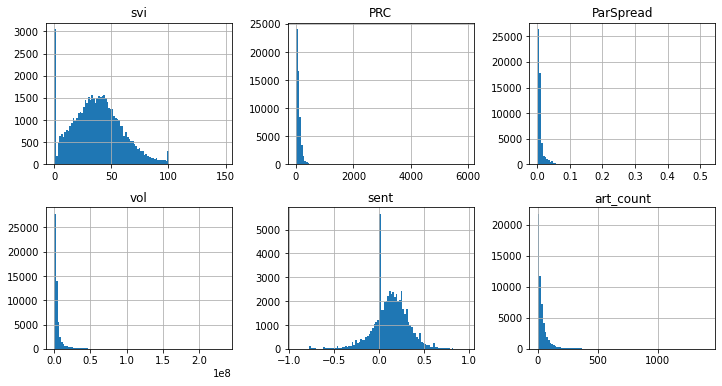

In [ ]:
_ = df_clean[['svi', 'PRC',	'ParSpread', 'vol', 'sent', 'art_count']].hist(layout=(2,3), bins=100, figsize=(12,6))

# Panel Data Code

This is the code I used for the stats. There are no good packages for panel data in python, so I needed to do this all in numpy. 

In [ ]:
def get_DH_z_vals(y_arr, P, y_loc=0, x_loc=2):
  '''
  This runs the DH test. 
  '''
  (M,N,T,K) = y_arr.shape
  Ti = T - P
  y_t = y_arr[:,:,P:(Ti+P),y_loc:(y_loc+1)]
  y_vals = np.array([y_arr[:,:,i:i+P,y_loc] for i in range(Ti)]).transpose((1,2,0,3)) 
  x_vals = np.array([y_arr[:,:,i:i+P,x_loc] for i in range(Ti)]).transpose((1,2,0,3))
  z_vals = np.concatenate((np.ones((M,N,Ti,1)),y_vals,x_vals), axis=3)
  R_arr = np.eye(P,2*P+1,P+1)
  R_T = R_arr.transpose()
  z_T = z_vals.transpose((0,1,3,2))
  z_var_inv = np.linalg.inv(z_T @  z_vals)
  coefs = z_var_inv @ z_T @ y_t
  coefs_T = coefs.transpose(0,1,3,2)
  e_hat = y_t - z_vals @ coefs
  sig_hat = e_hat.transpose(0,1,3,2) @ e_hat * (Ti-2*P-1)**(-1)
  W_i = coefs_T @ R_T @ np.linalg.inv(sig_hat * (R_arr @ z_var_inv @ R_T)) @ R_arr @ coefs
  W_bar = np.mean(W_i, axis=(1,2,3))
  a = np.sqrt(N/(2*P)*(Ti-2*P-5)/(Ti-P-3))
  b = (Ti-2*P-3)/(Ti-2*P-1)
  Z_tild = a * (b * W_bar - P)
  return (Z_tild,W_i, e_hat)



In [ ]:
def bootstrap_DH(y_arr, P, y_loc=0, x_loc=2, bs_i=100, rng=np.random.default_rng()):
  '''
  This is a bootstrap ver of the DH test.
  '''
  (M,N,T,K) = y_arr.shape
  Ti = T - P
  Z_tild_hat = get_DH_z_vals(y_arr,P=P, y_loc=y_loc, x_loc=x_loc)[0]
  y_t = y_arr[:,:,P:(Ti+P),y_loc:(y_loc+1)]
  x_t = y_arr[:,:,P:(Ti+P),x_loc:(x_loc+1)]
  y_vals = np.array([y_arr[:,:,i:i+P,y_loc] for i in range(Ti)]).transpose((1,2,0,3)) 
  x_vals = np.array([y_arr[:,:,i:i+P,x_loc] for i in range(Ti)]).transpose((1,2,0,3))
  #print(x_vals.shape)
  z_vals = np.concatenate((np.ones((M,N,Ti,1)),y_vals,x_vals), axis=3)
  z_T = z_vals.transpose((0,1,3,2))
  z_var_inv = np.linalg.inv(z_T @  z_vals)
  coefs_ols = z_var_inv @ z_T @ y_t
  R_arr = np.eye(P,2*P+1,P+1)
  R_T = R_arr.transpose()
  coefs_rs = coefs_ols - z_var_inv @ R_T @ np.linalg.inv(R_arr @ z_var_inv @ R_T) @ R_arr @ coefs_ols 

  y_hat = z_vals @ coefs_rs 
  e_raw = y_t - y_hat
  e_bar = e_raw.mean(axis=2)
  e_hat = e_raw - e_bar[:,:,None,:] 


  Z_res = []
  y_star = y_arr[:,:,P:].copy()
  y_star[:,:,:,x_loc:(x_loc+1)] = rng.permuted(y_star[:,:,:,x_loc:(x_loc+1)] , axis=2) #this makes sure the null hyp is true
  for _ in  tqdm(range(bs_i)):
    e_star = rng.choice(e_hat, size=e_hat.shape[2], axis=2)
    y_star[:,:,:,y_loc:(y_loc+1)] = y_hat + e_star
    Z_star = get_DH_z_vals(y_star,P=P, y_loc=y_loc, x_loc=x_loc)[0]
    Z_res.append(Z_star)
  
  res = (Z_tild_hat,Z_res, e_hat, y_star, coefs_rs)

  return res

In [ ]:
def get_ll_test_stat_2(y_arr, P, y_loc=0, x_loc=2, w_loc=1):
'''
  This gets the mean test stat used in the three var case
  '''
  (M,N,T,K) = y_arr.shape
  Ti = T - P
  y_t = y_arr[:,:,P:(Ti+P),y_loc:(y_loc+1)].copy()
  y_vals = np.array([y_arr[:,:,i:i+P,y_loc] for i in range(Ti)]).transpose((1,2,0,3)) 
  x_vals = np.array([y_arr[:,:,i:i+P,x_loc] for i in range(Ti)]).transpose((1,2,0,3))
  w_vals = np.array([y_arr[:,:,i:i+P,w_loc] for i in range(Ti)]).transpose((1,2,0,3))
  z_f = np.concatenate((np.ones((M,N,Ti,1)),y_vals,w_vals, x_vals), axis=3)
  z_r = np.concatenate((np.ones((M,N,Ti,1)),y_vals,w_vals), axis=3)
  z_f_T = z_f.transpose((0,1,3,2))
  z_r_T = z_r.transpose((0,1,3,2))

  z_f_inv = np.linalg.inv(z_f_T @  z_f)
  z_r_inv = np.linalg.inv(z_r_T @  z_r)
  coefs_f = z_f_inv @ z_f_T @ y_t

  coefs_r = z_r_inv @ z_r_T @ y_t
  e_f_hat = y_t - z_f @ coefs_f
  e_r_hat = y_t - z_r @ coefs_r
  sig_f_hat = e_f_hat.transpose(0,1,3,2) @ e_f_hat 
  sig_r_hat = e_r_hat.transpose(0,1,3,2) @ e_r_hat 

  F_i = (-np.log(sig_r_hat) +np.log(sig_f_hat))
  d1 = P/2
  d2 =  (Ti - 2*P)/2
  W_i = (1 - np.exp(F_i)) # This should roughly follow a beta dist
  W_bar = np.mean(W_i, axis=(1,2,3))
  z_mean = d1/(d1+d2)
  z_var = (d1*d2)/((d1+d2)**2*(d1+d2+1))
  z_se = (z_var/N)**(0.5)
  Z_tild = 1/z_se * (W_bar - z_mean) #scale it to make it easier to read
  return (Z_tild,W_i, e_f_hat, e_r_hat)

In [ ]:
def bootstrap_LL_2(y_arr, P, y_loc=0, x_loc=2, w_loc=1, bs_i=100, rng=np.random.default_rng()):
  '''
  Bootstrap method used in paper
  '''
  (M,N,T,K) = y_arr.shape
  Ti = T - P
  Z_tild_hat = get_ll_test_stat(y_arr,P=P, y_loc=y_loc, x_loc=x_loc, w_loc=w_loc)[0]
  y_t = y_arr[:,:,P:(Ti+P),y_loc:(y_loc+1)]
  x_t = y_arr[:,:,P:(Ti+P),x_loc:(x_loc+1)]
  w_t = y_arr[:,:,P:(Ti+P),w_loc:(w_loc+1)]
  y_vals = np.array([y_arr[:,:,i:i+P,y_loc] for i in range(Ti)]).transpose((1,2,0,3)) 
  x_vals = np.array([y_arr[:,:,i:i+P,x_loc] for i in range(Ti)]).transpose((1,2,0,3))
  w_vals = np.array([y_arr[:,:,i:i+P,w_loc] for i in range(Ti)]).transpose((1,2,0,3))

  z_vals = np.concatenate((np.ones((M,N,Ti,1)),y_vals,w_vals,x_vals), axis=3)
  z_T = z_vals.transpose((0,1,3,2))
  z_var_inv = np.linalg.inv(z_T @  z_vals)
  coefs_ols = z_var_inv @ z_T @ y_t
  R_arr = np.eye(P,3*P+1,2*P+1)
  R_T = R_arr.transpose()
  coefs_rs = coefs_ols - z_var_inv @ R_T @ np.linalg.inv(R_arr @ z_var_inv @ R_T) @ R_arr @ coefs_ols 
  y_hat = z_vals @ coefs_rs 
  e_raw = y_t - y_hat
  e_bar = e_raw.mean(axis=2)
  e_hat = e_raw - e_bar[:,:,None,:] 
  
  Z_res = []
  y_star = y_arr[:,:,P:].copy()
  y_star[:,:,:,x_loc:(x_loc+1)] = rng.permuted(y_star[:,:,:,x_loc:(x_loc+1)] , axis=2) #this makes sure the null hyp is true
  for _ in  tqdm(range(bs_i),desc='LL_test',position=0):
    e_star = rng.choice(e_hat, size=e_hat.shape[2], axis=2)
    y_star[:,:,:,y_loc:(y_loc+1)] = y_hat + e_star
    Z_star = get_ll_test_stat(y_star,P=P, y_loc=y_loc, x_loc=x_loc, w_loc=w_loc)[0]
    Z_res.append(Z_star)
  
  res = (Z_tild_hat,Z_res, e_hat, y_star, coefs_rs)

  return res

In [ ]:
df_clean

,ticker,date,svi,PRC,market_cap_mean,vol,td_count,vol_sum,ParSpread,sent,...,svi_diff,svi_med,count_diff,count_med,PRC_diff,Par_diff,vol_diff,vol_sum_diff,time_idx,year
67,A,2016-09-18,0.000000,45.148,1.747404e+07,2245778.60,5,11228893.0,0.008125,0.2598,...,-3.486355,-3.081570,0.485508,1.067083,-0.029291,-0.159956,0.339790,0.562933,0,2016
68,A,2016-09-25,0.000000,45.996,1.747404e+07,1827572.80,5,9137864.0,0.008655,0.3046,...,0.000000,-3.081570,-0.167054,0.620221,0.018608,0.063169,-0.206064,-0.206064,1,2016
69,A,2016-10-02,0.000000,46.790,1.747404e+07,1884254.00,5,9421270.0,0.008422,0.4588,...,0.000000,-3.081570,-1.011601,-0.626381,0.017115,-0.027292,0.030543,0.030543,2,2016
70,A,2016-10-09,17.000000,47.160,1.747404e+07,1634361.20,5,8171806.0,0.008056,-0.0165,...,2.890372,-0.125971,0.223144,-0.235002,0.007877,-0.044475,-0.142280,-0.142280,3,2016
71,A,2016-10-16,15.000000,45.818,1.747404e+07,1705346.20,5,8526731.0,0.008631,0.2301,...,-0.117783,-0.178728,0.470004,0.470004,-0.028869,0.068952,0.042516,0.042516,4,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83075,YUM,2022-03-06,49.066310,120.606,2.154346e+07,1667732.80,5,8338664.0,0.015166,-0.1807,...,0.090002,0.076109,0.929536,0.260284,-0.017091,0.017127,-0.191900,0.031244,285,2022
83076,YUM,2022-03-13,55.358160,115.328,2.154346e+07,2196543.80,5,10982719.0,0.016846,0.0268,...,0.118379,0.149487,-0.305382,-0.045098,-0.044749,0.105043,0.275420,0.275420,286,2022
83077,YUM,2022-03-20,36.892939,117.728,2.154346e+07,2416518.80,5,12082594.0,0.017058,0.2055,...,-0.396962,-0.330047,-0.287682,-0.369834,0.020597,0.012535,0.095443,0.095443,287,2022
83078,YUM,2022-03-27,46.384245,118.498,2.154346e+07,1604409.60,5,8022048.0,0.016272,0.1121,...,0.223525,-0.023951,0.174353,-0.195480,0.006519,-0.047165,-0.409572,-0.409572,288,2022


In [ ]:
df_clean.columns

Index(['ticker', 'date', 'svi', 'PRC', 'market_cap_mean', 'vol', 'td_count',
       'vol_sum', 'ParSpread', 'sent', 'art_count', 'sector', 'svi_diff',
       'svi_med', 'count_diff', 'count_med', 'PRC_diff', 'Par_diff',
       'vol_diff', 'vol_sum_diff', 'time_idx', 'year'],
      dtype='object')

In [ ]:
var_list

['svi_med', 'PRC_diff', 'Par_diff', 'vol_diff', 'sent', 'count_med']

In [ ]:
var_list = ['svi_med', 'PRC_diff', 'Par_diff', 'vol_diff', 'sent', 'count_med']

I wrote the code with the monte carlo simulation in mind, thus you'll need to insert an axes of length one to the front.

In [ ]:
clean_arr = np.array([df_clean[df_clean['ticker']== val][var_list].values for val in df_clean['ticker'].unique()])[None,...]

In [ ]:
clean_arr.shape

(1, 194, 290, 6)

In [ ]:
dh_test = get_DH_z_vals(clean_arr, 4, y_loc=2, x_loc=0)

In [ ]:
dh_test = get_DH_z_vals(clean_arr, 4, y_loc=2, x_loc=5)

In [ ]:
dh_test[0]

array([-1.94083063])

In [ ]:
yarr = clean_arr
P = 6
var_n = len(var_list)
pg_res = np.zeros((var_n,var_n,2))
for i in range(var_n):
  for j in range(var_n):
    if i==j:
      continue
    dh_val = get_DH_z_vals(yarr, P, y_loc=i, x_loc=j)[0]
    pg_res[i,j,0] = dh_val
    #pg_res[i,j,1] = 2*(1-stats.norm.cdf(np.absolute(dh_val)))
    pg_res[i,j,1] = (1-stats.norm.cdf(dh_val))





In [ ]:
pg_res.shape

(6, 6, 2)

In [ ]:
pd.DataFrame(pg_res.round(4).tolist(), index=var_list, columns=var_list)

,svi_med,PRC_diff,Par_diff,vol_diff,sent,count_med
svi_med,"[0.0, 0.0]","[-1.7753, 0.9621]","[2.6667, 0.0038]","[6.4917, 0.0]","[3.7128, 0.0001]","[6.2165, 0.0]"
PRC_diff,"[3.5496, 0.0002]","[0.0, 0.0]","[23.872, 0.0]","[4.1871, 0.0]","[20.7914, 0.0]","[-4.8794, 1.0]"
Par_diff,"[3.1352, 0.0009]","[31.0415, 0.0]","[0.0, 0.0]","[8.1764, 0.0]","[3.9642, 0.0]","[-2.2626, 0.9882]"
vol_diff,"[264.8042, 0.0]","[15.3182, 0.0]","[8.0457, 0.0]","[0.0, 0.0]","[2.7574, 0.0029]","[183.0691, 0.0]"
sent,"[2.8948, 0.0019]","[-2.933, 0.9983]","[-0.3895, 0.6516]","[-0.3945, 0.6534]","[0.0, 0.0]","[8.1823, 0.0]"
count_med,"[8.408, 0.0]","[-6.1302, 1.0]","[0.0139, 0.4945]","[6.5133, 0.0]","[15.2538, 0.0]","[0.0, 0.0]"


In [ ]:
pd.DataFrame(pg_res.round(4).tolist(), index=var_list, columns=var_list).to_latex()

'\\begin{tabular}{lllllll}\n\\toprule\n{} &           svi\\_med &           PRC\\_diff &           Par\\_diff &           vol\\_diff &              sent &          count\\_med \\\\\n\\midrule\nsvi\\_med   &        [0.0, 0.0] &  [-1.7753, 0.9621] &   [2.6667, 0.0038] &      [6.4917, 0.0] &  [3.7128, 0.0001] &      [6.2165, 0.0] \\\\\nPRC\\_diff  &  [3.5496, 0.0002] &         [0.0, 0.0] &      [23.872, 0.0] &      [4.1871, 0.0] &    [20.7914, 0.0] &     [-4.8794, 1.0] \\\\\nPar\\_diff  &  [3.1352, 0.0009] &     [31.0415, 0.0] &         [0.0, 0.0] &      [8.1764, 0.0] &     [3.9642, 0.0] &  [-2.2626, 0.9882] \\\\\nvol\\_diff  &   [264.8042, 0.0] &     [15.3182, 0.0] &      [8.0457, 0.0] &         [0.0, 0.0] &  [2.7574, 0.0029] &    [183.0691, 0.0] \\\\\nsent      &  [2.8948, 0.0019] &   [-2.933, 0.9983] &  [-0.3895, 0.6516] &  [-0.3945, 0.6534] &        [0.0, 0.0] &      [8.1823, 0.0] \\\\\ncount\\_med &      [8.408, 0.0] &     [-6.1302, 1.0] &   [0.0139, 0.4945] &      [6.5133, 0.0] &   

This is the DH test results. Next, we should find the lag order. 



In [ ]:
from statsmodels.tsa.ar_model import ar_select_order

In [ ]:
lag_list_1 = [len(ar_select_order(clean_arr[0,i,:,0], maxlag=20, ic='bic').ar_lags) for i in range(clean_arr.shape[1])]
lag_list_2 = [len(ar_select_order(clean_arr[0,i,:,1], maxlag=20, ic='bic').ar_lags) for i in range(clean_arr.shape[1])]
lag_list_3 = [len(ar_select_order(clean_arr[0,i,:,2], maxlag=20, ic='bic').ar_lags) for i in range(clean_arr.shape[1])]
lag_list_4 = [len(ar_select_order(clean_arr[0,i,:,3], maxlag=20, ic='bic').ar_lags) for i in range(clean_arr.shape[1])]
lag_list_5 = [len(ar_select_order(clean_arr[0,i,:,4], maxlag=20, ic='bic').ar_lags) for i in range(clean_arr.shape[1])]
lag_list_6 = [len(ar_select_order(clean_arr[0,i,:,5], maxlag=20, ic='bic').ar_lags) for i in range(clean_arr.shape[1])]

In [ ]:
lag_arr = np.array([lag_list_1,lag_list_2,lag_list_3,lag_list_4,lag_list_5,lag_list_6]).transpose()

In [ ]:
lag_arr.shape

(194, 6)

In [ ]:
var_list

['svi_med', 'PRC_diff', 'Par_diff', 'vol_diff', 'sent', 'count_med']

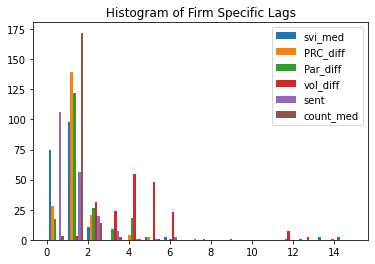

In [ ]:
fig, ax0 = plt.subplots()

#colors = ['red', 'tan', 'lime']
ax0.hist(lag_arr, bins=lag_arr.max()+1,  histtype='bar',  label=var_list)
ax0.legend(prop={'size': 10})
ax0.set_title('Histogram of Firm Specific Lags')

plt.show()

I think we should use a lag order of 6. Let's look at the bootstrap method now. 

In [ ]:
ll_test = get_ll_test_stat_2(clean_arr, 6, y_loc=2, x_loc=0, w_loc=1)

In [ ]:
#ll_test = get_ll_test_stat_2(clean_arr, 6, y_loc=2, x_loc=4, w_loc=1)

In [ ]:
ll_test[0]

array([3.89817316])

In [ ]:
LL_bs_test = bootstrap_LL_2(clean_arr, 6, y_loc=2, x_loc=0, w_loc=1, bs_i=1000, rng=np.random.default_rng())

100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]


In [ ]:
LL_cr = np.percentile(np.array(LL_bs_test[1]), (5,95), axis=0)

In [ ]:
LL_bs_test[0]

array([3.89817316])

In [ ]:
LL_cr.transpose()

array([[-1.03587692,  2.30689138]])

In [ ]:
['svi_med', 'PRC_diff', 'Par_diff', 'vol_diff', 'sent', 'count_med']

['svi_med', 'PRC_diff', 'Par_diff', 'vol_diff', 'sent', 'count_med']

In [ ]:
LL_res = []
#P = 4
P = 6
bs_m = 1000
rng_m = np.random.default_rng()
for i in [0,3,4,5]:
  LL_bs = bootstrap_LL_2(clean_arr, P, y_loc=2, x_loc=i, w_loc=1, bs_i=bs_m, rng=rng_m)
  LL_cr = np.percentile(np.array(LL_bs[1]), (5,95), axis=0)
  subres = (np.squeeze(LL_bs[0]), np.squeeze(LL_cr.transpose()))
  LL_res.append(subres)

100%|██████████| 1000/1000 [01:17<00:00, 12.83it/s]


In [ ]:
LL_res

[(array(3.89817316), array([-0.86081489,  2.56071091])),
 (array(7.93248589), array([-1.14263537,  2.08020241])),
 (array(4.59548598), array([-0.88580999,  2.3930673 ])),
 (array(-1.82505553), array([-1.03910696,  2.50793419]))]

So, even conditioned on stock price, it appears that search volumes, trading volume, and news sentiment are all important. News volume not so much. 

In [ ]:
LL_res = []
#P = 4
P = 6
bs_m = 1000
rng_m = np.random.default_rng()
for i in [1,3,4,5]:
  LL_bs = bootstrap_LL_2(clean_arr, P, y_loc=2, x_loc=0, w_loc=i, bs_i=bs_m, rng=rng_m)
  LL_cr = np.percentile(np.array(LL_bs[1]), (5,95), axis=0)
  subres = (np.squeeze(LL_bs[0]), np.squeeze(LL_cr.transpose()))
  LL_res.append(subres)

100%|██████████| 1000/1000 [01:13<00:00, 13.66it/s]


In [ ]:
LL_res

[(array(3.89817316), array([-1.02556213,  2.38403258])),
 (array(2.38383156), array([-1.19079418,  2.16316662])),
 (array(3.80348283), array([-1.06448537,  2.38032011])),
 (array(4.19959682), array([-1.0753027 ,  2.42768604]))]

It appears search volumes are still important when condtioned on other things

In [ ]:
LL_res = []
#P = 4
P = 6
bs_m = 1000
rng_m = np.random.default_rng()
for i in [0,1,3,4]:
  LL_bs = bootstrap_LL_2(clean_arr, P, y_loc=2, x_loc=5, w_loc=i, bs_i=bs_m, rng=rng_m)
  LL_cr = np.percentile(np.array(LL_bs[1]), (5,95), axis=0)
  subres = (np.squeeze(LL_bs[0]), np.squeeze(LL_cr.transpose()))
  LL_res.append(subres)

100%|██████████| 1000/1000 [01:34<00:00, 10.57it/s]


In [ ]:
LL_res

[(array(-1.0947047), array([-1.24835726,  2.02176995])),
 (array(-1.82505553), array([-0.73901854,  2.61330707])),
 (array(-1.28670993), array([-0.8298996,  2.805105 ])),
 (array(-2.00811615), array([-0.79224291,  2.58201585]))]

There doesn't appear to be any impact from news volume. Now, lets look at the subsets. 


In [ ]:

large_arr = np.array([df_large[df_large['ticker']== val][var_list].values for val in df_large['ticker'].unique()])[None,...]
small_arr = np.array([df_small[df_small['ticker']== val][var_list].values for val in df_small['ticker'].unique()])[None,...]

In [ ]:
large_arr.shape

(1, 50, 290, 6)

In [ ]:
small_arr.shape

(1, 144, 290, 6)

In [ ]:
yarr = large_arr
P = 6
var_n = len(var_list)
pg_res = np.zeros((var_n,var_n,2))
for i in range(var_n):
  for j in range(var_n):
    if i==j:
      continue
    dh_val = get_DH_z_vals(yarr, P, y_loc=i, x_loc=j)[0]
    pg_res[i,j,0] = dh_val
    #pg_res[i,j,1] = 2*(1-stats.norm.cdf(np.absolute(dh_val)))
    pg_res[i,j,1] = (1-stats.norm.cdf(dh_val))

In [ ]:
pd.DataFrame(pg_res.round(4).tolist(), index=var_list, columns=var_list)

,svi_med,PRC_diff,Par_diff,vol_diff,sent,count_med
svi_med,"[0.0, 0.0]","[0.4703, 0.3191]","[3.8877, 0.0001]","[7.7077, 0.0]","[0.0185, 0.4926]","[4.0002, 0.0]"
PRC_diff,"[7.0744, 0.0]","[0.0, 0.0]","[11.7513, 0.0]","[2.8986, 0.0019]","[14.7062, 0.0]","[-1.5363, 0.9378]"
Par_diff,"[2.7635, 0.0029]","[17.6819, 0.0]","[0.0, 0.0]","[6.408, 0.0]","[2.0332, 0.021]","[-1.1745, 0.8799]"
vol_diff,"[296.7485, 0.0]","[9.2933, 0.0]","[5.4348, 0.0]","[0.0, 0.0]","[2.0136, 0.022]","[113.5828, 0.0]"
sent,"[2.2035, 0.0138]","[-1.5513, 0.9396]","[-0.8266, 0.7958]","[-1.3487, 0.9113]","[0.0, 0.0]","[3.6858, 0.0001]"
count_med,"[5.2371, 0.0]","[-2.5499, 0.9946]","[-0.9908, 0.8391]","[2.356, 0.0092]","[5.6889, 0.0]","[0.0, 0.0]"


In [ ]:
pd.DataFrame(pg_res.round(4).tolist(), index=var_list, columns=var_list).to_latex()

'\\begin{tabular}{lllllll}\n\\toprule\n{} &           svi\\_med &           PRC\\_diff &           Par\\_diff &           vol\\_diff &              sent &          count\\_med \\\\\n\\midrule\nsvi\\_med   &        [0.0, 0.0] &   [0.4703, 0.3191] &   [3.8877, 0.0001] &      [7.7077, 0.0] &  [0.0185, 0.4926] &      [4.0002, 0.0] \\\\\nPRC\\_diff  &     [7.0744, 0.0] &         [0.0, 0.0] &     [11.7513, 0.0] &   [2.8986, 0.0019] &    [14.7062, 0.0] &  [-1.5363, 0.9378] \\\\\nPar\\_diff  &  [2.7635, 0.0029] &     [17.6819, 0.0] &         [0.0, 0.0] &       [6.408, 0.0] &   [2.0332, 0.021] &  [-1.1745, 0.8799] \\\\\nvol\\_diff  &   [296.7485, 0.0] &      [9.2933, 0.0] &      [5.4348, 0.0] &         [0.0, 0.0] &   [2.0136, 0.022] &    [113.5828, 0.0] \\\\\nsent      &  [2.2035, 0.0138] &  [-1.5513, 0.9396] &  [-0.8266, 0.7958] &  [-1.3487, 0.9113] &        [0.0, 0.0] &   [3.6858, 0.0001] \\\\\ncount\\_med &     [5.2371, 0.0] &  [-2.5499, 0.9946] &  [-0.9908, 0.8391] &    [2.356, 0.0092] &   

In [ ]:
yarr = small_arr
P = 6
var_n = len(var_list)
pg_res = np.zeros((var_n,var_n,2))
for i in range(var_n):
  for j in range(var_n):
    if i==j:
      continue
    dh_val = get_DH_z_vals(yarr, P, y_loc=i, x_loc=j)[0]
    pg_res[i,j,0] = dh_val
    #pg_res[i,j,1] = 2*(1-stats.norm.cdf(np.absolute(dh_val)))
    pg_res[i,j,1] = (1-stats.norm.cdf(dh_val))

In [ ]:
pd.DataFrame(pg_res.round(4).tolist(), index=var_list, columns=var_list)

,svi_med,PRC_diff,Par_diff,vol_diff,sent,count_med
svi_med,"[0.0, 0.0]","[-2.3377, 0.9903]","[0.8044, 0.2106]","[2.9931, 0.0014]","[4.2986, 0.0]","[4.8583, 0.0]"
PRC_diff,"[-0.0486, 0.5194]","[0.0, 0.0]","[20.7836, 0.0]","[3.1519, 0.0008]","[15.4668, 0.0]","[-4.7583, 1.0]"
Par_diff,"[2.0107, 0.0222]","[25.6106, 0.0]","[0.0, 0.0]","[5.7143, 0.0]","[3.4031, 0.0003]","[-1.9342, 0.9735]"
vol_diff,"[132.4972, 0.0]","[12.3037, 0.0]","[6.1361, 0.0]","[0.0, 0.0]","[2.014, 0.022]","[145.5588, 0.0]"
sent,"[2.0615, 0.0196]","[-2.4902, 0.9936]","[0.035, 0.4861]","[0.3368, 0.3681]","[0.0, 0.0]","[7.3253, 0.0]"
count_med,"[6.6732, 0.0]","[-5.6128, 1.0]","[0.5999, 0.2743]","[6.1717, 0.0]","[14.3528, 0.0]","[0.0, 0.0]"


In [ ]:
pd.DataFrame(pg_res.round(4).tolist(), index=var_list, columns=var_list).to_latex()

'\\begin{tabular}{lllllll}\n\\toprule\n{} &            svi\\_med &           PRC\\_diff &          Par\\_diff &          vol\\_diff &              sent &          count\\_med \\\\\n\\midrule\nsvi\\_med   &         [0.0, 0.0] &  [-2.3377, 0.9903] &  [0.8044, 0.2106] &  [2.9931, 0.0014] &     [4.2986, 0.0] &      [4.8583, 0.0] \\\\\nPRC\\_diff  &  [-0.0486, 0.5194] &         [0.0, 0.0] &    [20.7836, 0.0] &  [3.1519, 0.0008] &    [15.4668, 0.0] &     [-4.7583, 1.0] \\\\\nPar\\_diff  &   [2.0107, 0.0222] &     [25.6106, 0.0] &        [0.0, 0.0] &     [5.7143, 0.0] &  [3.4031, 0.0003] &  [-1.9342, 0.9735] \\\\\nvol\\_diff  &    [132.4972, 0.0] &     [12.3037, 0.0] &     [6.1361, 0.0] &        [0.0, 0.0] &    [2.014, 0.022] &    [145.5588, 0.0] \\\\\nsent      &   [2.0615, 0.0196] &  [-2.4902, 0.9936] &   [0.035, 0.4861] &  [0.3368, 0.3681] &        [0.0, 0.0] &      [7.3253, 0.0] \\\\\ncount\\_med &      [6.6732, 0.0] &     [-5.6128, 1.0] &  [0.5999, 0.2743] &     [6.1717, 0.0] &    [14.35

This is the DH test results. Lets look at the 3 var case.

In [ ]:
LL_res_small = []
P = 6
#P = 4
bs_m = 1000
rng_m = np.random.default_rng()
for i in [0,3,4,5]:
  LL_bs = bootstrap_LL_2(small_arr, P, y_loc=2, x_loc=i, w_loc=1, bs_i=bs_m, rng=rng_m)
  LL_cr = np.percentile(np.array(LL_bs[1]), (5,95), axis=0)
  subres = (np.squeeze(LL_bs[0]), np.squeeze(LL_cr.transpose()))
  LL_res_small.append(subres)

100%|██████████| 1000/1000 [00:53<00:00, 18.64it/s]


In [ ]:
LL_res_small

[(array(2.65824861), array([-1.12060292,  2.39481695])),
 (array(5.75518824), array([-1.08992363,  2.30449495])),
 (array(4.05003563), array([-1.34367468,  1.92403002])),
 (array(-1.49582187), array([-1.4680415 ,  1.79647093]))]

In [ ]:
LL_res_large = []
P = 6
bs_m = 1000
rng_m = np.random.default_rng()
for i in [0,3,4,5]:
  LL_bs = bootstrap_LL_2(large_arr, P, y_loc=2, x_loc=i, w_loc=1, bs_i=bs_m, rng=rng_m)
  LL_cr = np.percentile(np.array(LL_bs[1]), (5,95), axis=0)
  subres = (np.squeeze(LL_bs[0]), np.squeeze(LL_cr.transpose()))
  LL_res_large.append(subres)

100%|██████████| 1000/1000 [00:18<00:00, 53.00it/s]


In [ ]:
LL_res_large

[(array(3.16731313), array([-1.45007084,  1.80377662])),
 (array(5.8583068), array([-1.49519046,  1.9097582 ])),
 (array(2.17891922), array([-1.36813227,  2.0962708 ])),
 (array(-1.05644857), array([-1.24086384,  2.09813958]))]

In [ ]:
LL_res_large_1 = []
P = 6
bs_m = 1000
rng_m = np.random.default_rng()
for i in [1,3,4,5]:
  LL_bs = bootstrap_LL_2(large_arr, P, y_loc=2, x_loc=0, w_loc=i, bs_i=bs_m, rng=rng_m)
  LL_cr = np.percentile(np.array(LL_bs[1]), (5,95), axis=0)
  subres = (np.squeeze(LL_bs[0]), np.squeeze(LL_cr.transpose()))
  LL_res_large_1.append(subres)

100%|██████████| 1000/1000 [00:19<00:00, 52.24it/s]


In [ ]:
LL_res_large_1

[(array(3.16731313), array([-1.23253561,  2.08235933])),
 (array(3.01531449), array([-1.26410279,  2.00711677])),
 (array(3.02299368), array([-1.46078799,  1.85359912])),
 (array(4.17292773), array([-1.48317672,  1.98901142]))]

In [ ]:
LL_res_small_1 = []
P = 6
bs_m = 1000
rng_m = np.random.default_rng()
for i in [1,3,4,5]:
  LL_bs = bootstrap_LL_2(small_arr, P, y_loc=2, x_loc=0, w_loc=i, bs_i=bs_m, rng=rng_m)
  LL_cr = np.percentile(np.array(LL_bs[1]), (5,95), axis=0)
  subres = (np.squeeze(LL_bs[0]), np.squeeze(LL_cr.transpose()))
  LL_res_small_1.append(subres)

100%|██████████| 1000/1000 [00:55<00:00, 18.16it/s]


In [ ]:
LL_res_small_1

[(array(2.65824861), array([-1.16101198,  2.18953914])),
 (array(0.99011986), array([-0.89481369,  2.59684054])),
 (array(2.6333827), array([-1.21017612,  2.29900607])),
 (array(2.41554668), array([-1.76138172,  1.69424821]))]

#Start of R code


I need to use the plm from R in the next part. 

In [ ]:
%%R
install.packages("plm")

(as ‘lib’ is unspecified)
































































	‘/tmp/RtmpEFy0t2/downloaded_packages’



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(svi_med ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "levinlin")


	Levin-Lin-Chu Unit-Root Test (ex. var.: Individual Intercepts)

data:  svi_med ~ 1
z = -196.77, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(svi_med ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "ips")


	Im-Pesaran-Shin Unit-Root Test (ex. var.: Individual Intercepts)

data:  svi_med ~ 1
Wtbar = -193.11, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(PRC_diff ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "levinlin")


	Levin-Lin-Chu Unit-Root Test (ex. var.: Individual Intercepts)

data:  PRC_diff ~ 1
z = -197.5, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(PRC_diff ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "ips")


	Im-Pesaran-Shin Unit-Root Test (ex. var.: Individual Intercepts)

data:  PRC_diff ~ 1
Wtbar = -189.64, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(Par_diff ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "levinlin")


	Levin-Lin-Chu Unit-Root Test (ex. var.: Individual Intercepts)

data:  Par_diff ~ 1
z = -166.85, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(Par_diff ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "ips")


	Im-Pesaran-Shin Unit-Root Test (ex. var.: Individual Intercepts)

data:  Par_diff ~ 1
Wtbar = -168.48, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(vol_diff ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "levinlin")


	Levin-Lin-Chu Unit-Root Test (ex. var.: Individual Intercepts)

data:  vol_diff ~ 1
z = -105.07, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(vol_diff ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "ips")


	Im-Pesaran-Shin Unit-Root Test (ex. var.: Individual Intercepts)

data:  vol_diff ~ 1
Wtbar = -195.95, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(sent ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "levinlin")


	Levin-Lin-Chu Unit-Root Test (ex. var.: Individual Intercepts)

data:  sent ~ 1
z = -212.01, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(sent ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "ips")


	Im-Pesaran-Shin Unit-Root Test (ex. var.: Individual Intercepts)

data:  sent ~ 1
Wtbar = -201, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(count_med ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "levinlin")


	Levin-Lin-Chu Unit-Root Test (ex. var.: Individual Intercepts)

data:  count_med ~ 1
z = -171.91, p-value < 2.2e-16
alternative hypothesis: stationarity



In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(count_med ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "ips")


	Im-Pesaran-Shin Unit-Root Test (ex. var.: Individual Intercepts)

data:  count_med ~ 1
Wtbar = -168.32, p-value < 2.2e-16
alternative hypothesis: stationarity



Thus, all the data is stationary. The original data is not. See:

In [ ]:
%%R -i df_clean
library(plm)
#purtest(pGrunfeld$inv, pmax = 4, exo = "intercept", test = "levinlin")
purtest(PRC ~ 1, data = df_clean, index = c("ticker", "date"), pmax = 6, test = "levinlin")


	Levin-Lin-Chu Unit-Root Test (ex. var.: Individual Intercepts)

data:  PRC ~ 1
z = 1.7794, p-value = 0.9624
alternative hypothesis: stationarity

